# Subject Repeat Analysis

Analyze if model predictions differ for subjects based on:
- Visit number (1st, 2nd, 3rd time)
- Team total visits (how many times the team came in)
- Desktop ID effects

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
%matplotlib inline

## Load Data

In [2]:
# Load subject accuracy data
accuracy_df = pd.read_csv('../../data/results/analysis_outputs_POST/subject_accuracy_with_sessions_POST.csv')
print(f"Accuracy data: {accuracy_df.shape}")
print(f"Columns: {accuracy_df.columns.tolist()}")
accuracy_df.head()

Accuracy data: (97, 10)
Columns: ['subject_id', 'desktop_id', 'team', 'session', 'date', 'accuracy', 'f1_score', 'num_trials', 'team_session_count', 'color']


,subject_id,desktop_id,team,session,date,accuracy,f1_score,num_trials,team_session_count,color
0,0823_1400_9M4VCHG,9M4VCHG,Team 15,Session 3,08/23/2021,1.000000,1.000000,132,2.0,orange
1,0917_1030_9M4VCHG,9M4VCHG,Team 22,Session 2,09/17/2021,1.000000,1.000000,129,2.0,orange
2,0930_1700_539136F,539136F,Team 25,Session 2,09/30/2021,1.000000,1.000000,190,2.0,orange
3,0831_1000_U9TEJGM,U9TEJGM,Team 20,Session 2,08/31/2021,0.969697,0.954779,132,2.0,orange
4,0924_1000_9M4VCHG,9M4VCHG,NaN,NaN,09/24/2021,0.969231,0.976679,130,NaN,gray


In [3]:
# Load session mapping with proper dtypes
session_mapping = pd.read_csv('../../data/results/analysis_outputs_POST/session_mapping_POST.csv', 
                              dtype={'mmdd': str, 'hhmm': str, 'user_id': str})
print(f"\nSession mapping: {session_mapping.shape}")
print(f"Columns: {session_mapping.columns.tolist()}")
session_mapping.head()


Session mapping: (99, 9)
Columns: ['filename', 'date', 'time', 'user_id', 'mmdd', 'hhmm', 'team', 'session', 'visit_number']


,filename,date,time,user_id,mmdd,hhmm,team,session,visit_number
0,preprocessing_0816_1400_9M4VCHG.json,08/16/2021,14:00,9M4VCHG,0816,1400,Team 12,Session 3,2.0
1,preprocessing_0924_1600_9M4VCHG.json,09/24/2021,16:00,9M4VCHG,0924,1600,Team 24,Session 3,3.0
2,preprocessing_0825_1000_9M4VCHG.json,08/25/2021,10:00,9M4VCHG,0825,1000,Team 17,Session 2,2.0
3,preprocessing_0813_1600_539136F.json,08/13/2021,16:00,539136F,0813,1600,Team 12,Session 2,1.0
4,preprocessing_0826_1000_539136F.json,08/26/2021,10:00,539136F,0826,1000,Team 17,Session 3,3.0


## Merge Data

In [4]:
# Create join key in session_mapping
session_mapping['join_key'] = session_mapping['mmdd'] + '_' + session_mapping['hhmm'] + '_' + session_mapping['user_id']

# Use subject_id from accuracy_df as join_key (already in mmdd_hhmm_userid format)
merged_df = accuracy_df.merge(
    session_mapping[['join_key', 'visit_number']],
    left_on='subject_id',
    right_on='join_key',
    how='left'
)

print(f"Merged data: {merged_df.shape}")
print(f"\nRecords with visit_number: {merged_df['visit_number'].notna().sum()} / {len(merged_df)}")
merged_df.head()

Merged data: (97, 12)

Records with visit_number: 91 / 97


,subject_id,desktop_id,team,session,date,accuracy,f1_score,num_trials,team_session_count,color,join_key,visit_number
0,0823_1400_9M4VCHG,9M4VCHG,Team 15,Session 3,08/23/2021,1.000000,1.000000,132,2.0,orange,0823_1400_9M4VCHG,2.0
1,0917_1030_9M4VCHG,9M4VCHG,Team 22,Session 2,09/17/2021,1.000000,1.000000,129,2.0,orange,0917_1030_9M4VCHG,2.0
2,0930_1700_539136F,539136F,Team 25,Session 2,09/30/2021,1.000000,1.000000,190,2.0,orange,0930_1700_539136F,2.0
3,0831_1000_U9TEJGM,U9TEJGM,Team 20,Session 2,08/31/2021,0.969697,0.954779,132,2.0,orange,0831_1000_U9TEJGM,1.0
4,0924_1000_9M4VCHG,9M4VCHG,NaN,NaN,09/24/2021,0.969231,0.976679,130,NaN,gray,0924_1000_9M4VCHG,NaN


## Compute Team Total Visits

In [5]:
# Count total visits per team
team_visit_counts = session_mapping.groupby('team')['visit_number'].max().reset_index()
team_visit_counts.columns = ['team', 'team_total_visits']

# Add to merged_df
merged_df = merged_df.merge(team_visit_counts, on='team', how='left')

print("Team total visits distribution:")
print(merged_df[merged_df['team_total_visits'].notna()]['team_total_visits'].value_counts().sort_index())
merged_df[['team', 'session', 'visit_number', 'team_total_visits']].head(10)

Team total visits distribution:
team_total_visits
1.0    14
2.0    52
3.0    25
Name: count, dtype: int64


,team,session,visit_number,team_total_visits
0,Team 15,Session 3,2.0,2.0
1,Team 22,Session 2,2.0,2.0
2,Team 25,Session 2,2.0,2.0
3,Team 20,Session 2,1.0,2.0
4,NaN,NaN,NaN,NaN
5,Team 23,Session 3,2.0,2.0
6,Team 17,Session 3,3.0,3.0
7,Team 22,Session 1,1.0,2.0
8,Team 23,Session 3,2.0,2.0
9,Team 26,Session 3,2.0,2.0


## Analysis: Accuracy by Visit Number

Accuracy by Visit Number:
                  mean       std  count       sem
visit_number                                     
1.0           0.654064  0.131219     49  0.018746
2.0           0.701331  0.191073     34  0.032769
3.0           0.650647  0.232683      8  0.082266


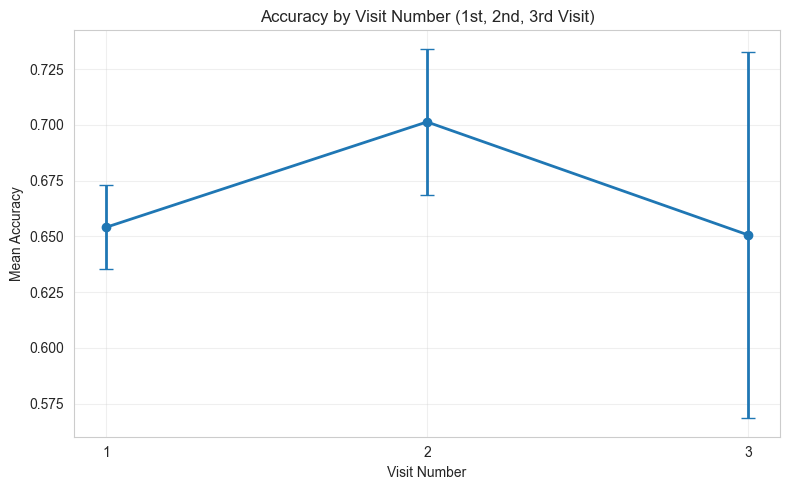

In [6]:
# Filter to records with visit_number
analysis_df = merged_df[merged_df['visit_number'].notna()].copy()

# Group by visit number
visit_accuracy = analysis_df.groupby('visit_number')['accuracy'].agg(['mean', 'std', 'count', 'sem'])
print("Accuracy by Visit Number:")
print(visit_accuracy)

# Plot
plt.figure(figsize=(8, 5))
plt.errorbar(visit_accuracy.index, visit_accuracy['mean'], 
             yerr=visit_accuracy['sem'], marker='o', capsize=5, linewidth=2)
plt.xlabel('Visit Number')
plt.ylabel('Mean Accuracy')
plt.title('Accuracy by Visit Number (1st, 2nd, 3rd Visit)')
plt.xticks([1, 2, 3])
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Analysis: Accuracy by Team Total Visits

Accuracy by Team Total Visits:
                       mean       std  count       sem
team_total_visits                                     
1.0                0.620382  0.077654     14  0.020754
2.0                0.691646  0.184265     52  0.025553
3.0                0.657945  0.156339     25  0.031268


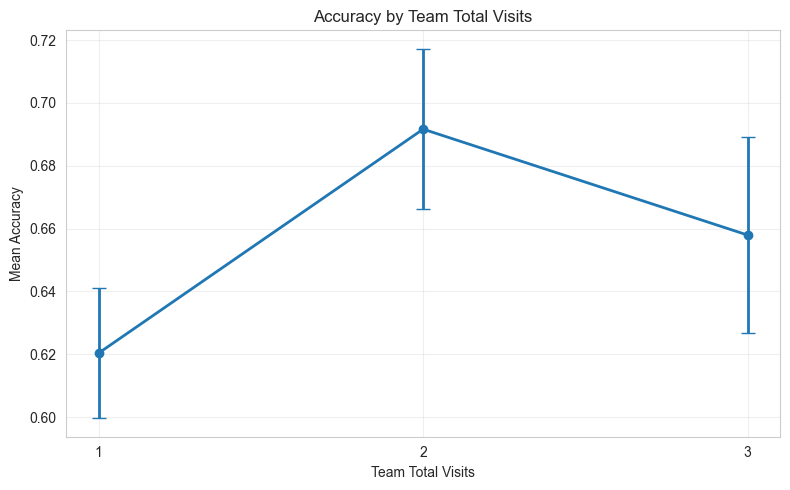

In [7]:
# Group by team total visits
team_visits_accuracy = analysis_df.groupby('team_total_visits')['accuracy'].agg(['mean', 'std', 'count', 'sem'])
print("Accuracy by Team Total Visits:")
print(team_visits_accuracy)

# Plot
plt.figure(figsize=(8, 5))
plt.errorbar(team_visits_accuracy.index, team_visits_accuracy['mean'], 
             yerr=team_visits_accuracy['sem'], marker='o', capsize=5, linewidth=2)
plt.xlabel('Team Total Visits')
plt.ylabel('Mean Accuracy')
plt.title('Accuracy by Team Total Visits')
plt.xticks([1, 2, 3])
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Analysis: Accuracy by Desktop ID

Accuracy by Desktop ID:
                mean       std  count       sem
desktop_id                                     
539136F     0.702316  0.176735     31  0.031742
U9TEJGM     0.671625  0.129278     30  0.023603
9M4VCHG     0.639300  0.183513     30  0.033505


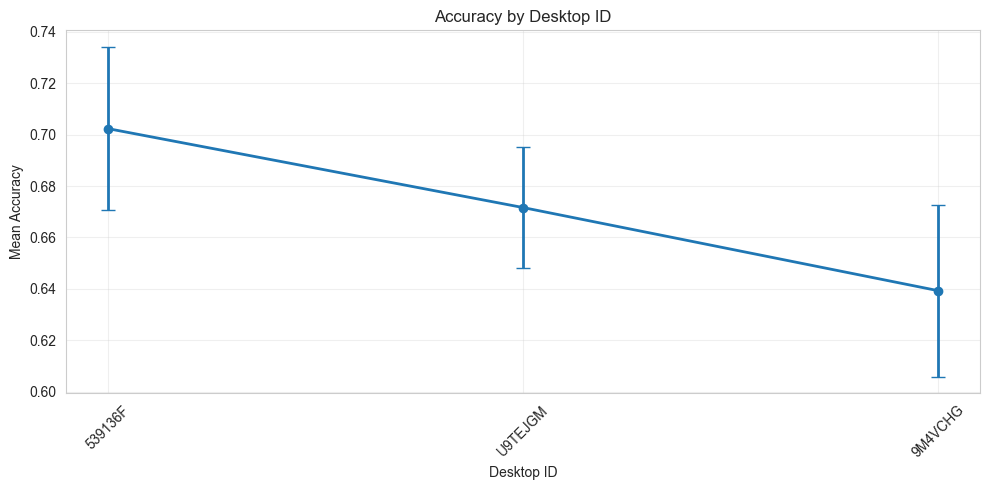

In [8]:
# Group by desktop ID
desktop_accuracy = analysis_df.groupby('desktop_id')['accuracy'].agg(['mean', 'std', 'count', 'sem'])
print("Accuracy by Desktop ID:")
print(desktop_accuracy.sort_values('mean', ascending=False))

# Plot
plt.figure(figsize=(10, 5))
desktop_accuracy_sorted = desktop_accuracy.sort_values('mean', ascending=False)
plt.errorbar(range(len(desktop_accuracy_sorted)), desktop_accuracy_sorted['mean'], 
             yerr=desktop_accuracy_sorted['sem'], marker='o', capsize=5, linewidth=2)
plt.xticks(range(len(desktop_accuracy_sorted)), desktop_accuracy_sorted.index, rotation=45)
plt.xlabel('Desktop ID')
plt.ylabel('Mean Accuracy')
plt.title('Accuracy by Desktop ID')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Interaction: Visit Number x Team Total Visits

Accuracy by Visit Number x Team Total Visits:
                                    mean  count       sem
visit_number team_total_visits                           
1.0          1.0                0.620382     14  0.020754
             2.0                0.673534     26  0.032415
             3.0                0.650211      9  0.023342
2.0          2.0                0.709758     26  0.039838
             3.0                0.673943      8  0.054342
3.0          3.0                0.650647      8  0.082266


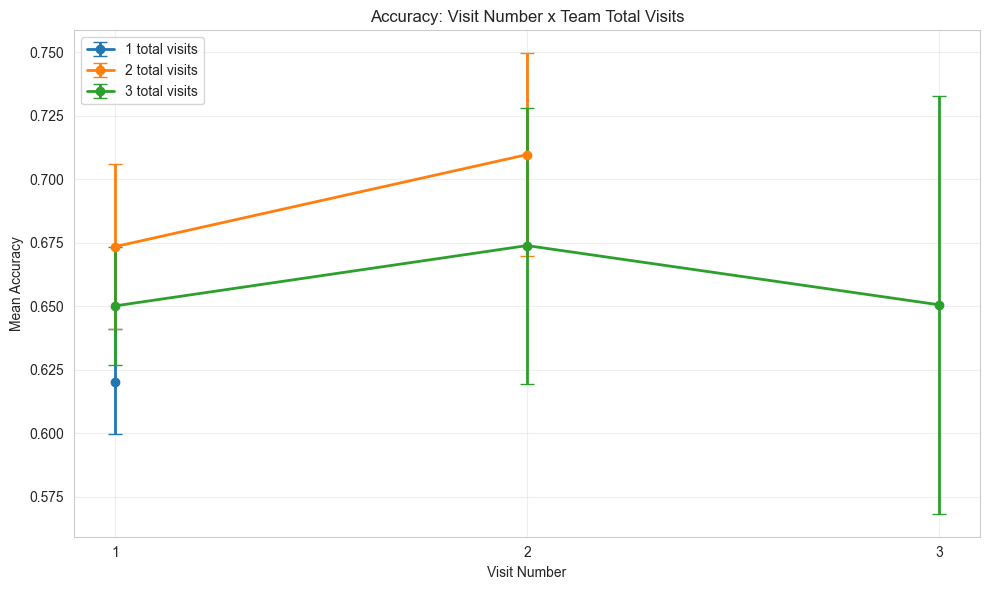

In [9]:
# Crosstab analysis
interaction = analysis_df.groupby(['visit_number', 'team_total_visits'])['accuracy'].agg(['mean', 'count', 'sem'])
print("Accuracy by Visit Number x Team Total Visits:")
print(interaction)

# Plot
plt.figure(figsize=(10, 6))
for total_visits in sorted(analysis_df['team_total_visits'].unique()):
    subset = interaction.xs(total_visits, level='team_total_visits')
    plt.errorbar(subset.index, subset['mean'], yerr=subset['sem'], 
                marker='o', capsize=5, linewidth=2, label=f'{int(total_visits)} total visits')

plt.xlabel('Visit Number')
plt.ylabel('Mean Accuracy')
plt.title('Accuracy: Visit Number x Team Total Visits')
plt.legend()
plt.xticks([1, 2, 3])
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Visualizations: Subject Accuracies by Visit Number

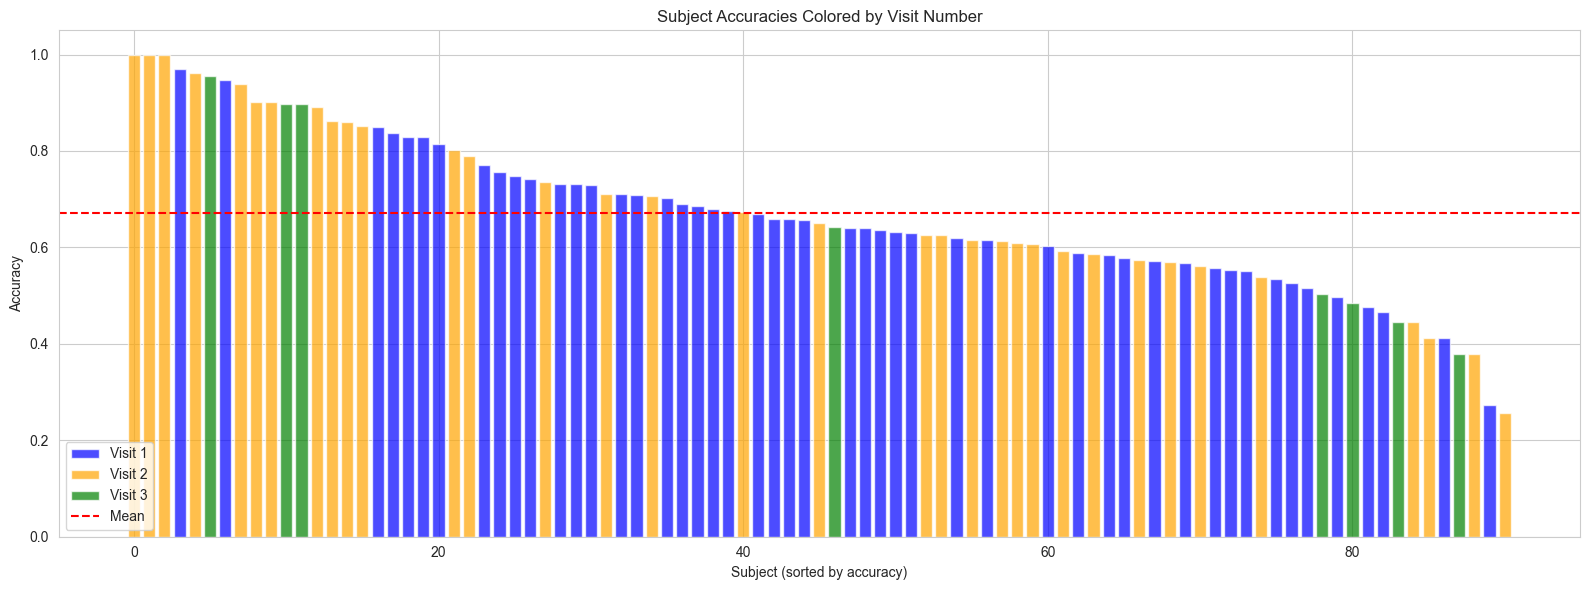

In [10]:
# Bar chart of all subject accuracies, colored by visit number
visit_colors = {1.0: 'blue', 2.0: 'orange', 3.0: 'green'}
analysis_df_sorted = analysis_df.sort_values('accuracy', ascending=False).reset_index(drop=True)

plt.figure(figsize=(16, 6))
colors = [visit_colors.get(v, 'gray') for v in analysis_df_sorted['visit_number']]
plt.bar(range(len(analysis_df_sorted)), analysis_df_sorted['accuracy'], color=colors, alpha=0.7)
plt.xlabel('Subject (sorted by accuracy)')
plt.ylabel('Accuracy')
plt.title('Subject Accuracies Colored by Visit Number')
plt.ylim(0, 1.05)
plt.axhline(y=analysis_df_sorted['accuracy'].mean(), color='red', linestyle='--', label='Mean')

# Legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='blue', alpha=0.7, label='Visit 1'),
    Patch(facecolor='orange', alpha=0.7, label='Visit 2'),
    Patch(facecolor='green', alpha=0.7, label='Visit 3'),
    plt.Line2D([0], [0], color='red', linestyle='--', label='Mean')
]
plt.legend(handles=legend_elements, loc='lower left')
plt.tight_layout()
plt.show()

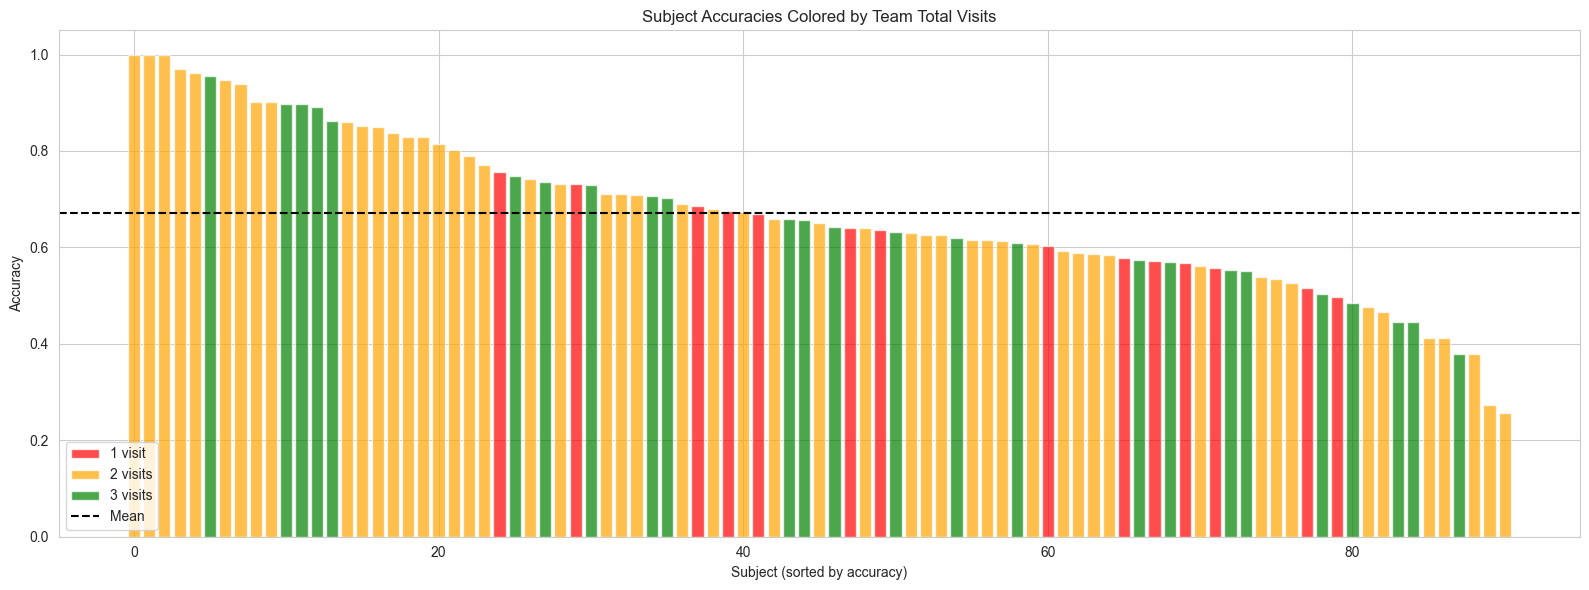

In [11]:
# Bar chart colored by team total visits
team_colors = {1.0: 'red', 2.0: 'orange', 3.0: 'green'}

plt.figure(figsize=(16, 6))
colors = [team_colors.get(v, 'gray') for v in analysis_df_sorted['team_total_visits']]
plt.bar(range(len(analysis_df_sorted)), analysis_df_sorted['accuracy'], color=colors, alpha=0.7)
plt.xlabel('Subject (sorted by accuracy)')
plt.ylabel('Accuracy')
plt.title('Subject Accuracies Colored by Team Total Visits')
plt.ylim(0, 1.05)
plt.axhline(y=analysis_df_sorted['accuracy'].mean(), color='black', linestyle='--', label='Mean')

# Legend
legend_elements = [
    Patch(facecolor='red', alpha=0.7, label='1 visit'),
    Patch(facecolor='orange', alpha=0.7, label='2 visits'),
    Patch(facecolor='green', alpha=0.7, label='3 visits'),
    plt.Line2D([0], [0], color='black', linestyle='--', label='Mean')
]
plt.legend(handles=legend_elements, loc='lower left')
plt.tight_layout()
plt.show()

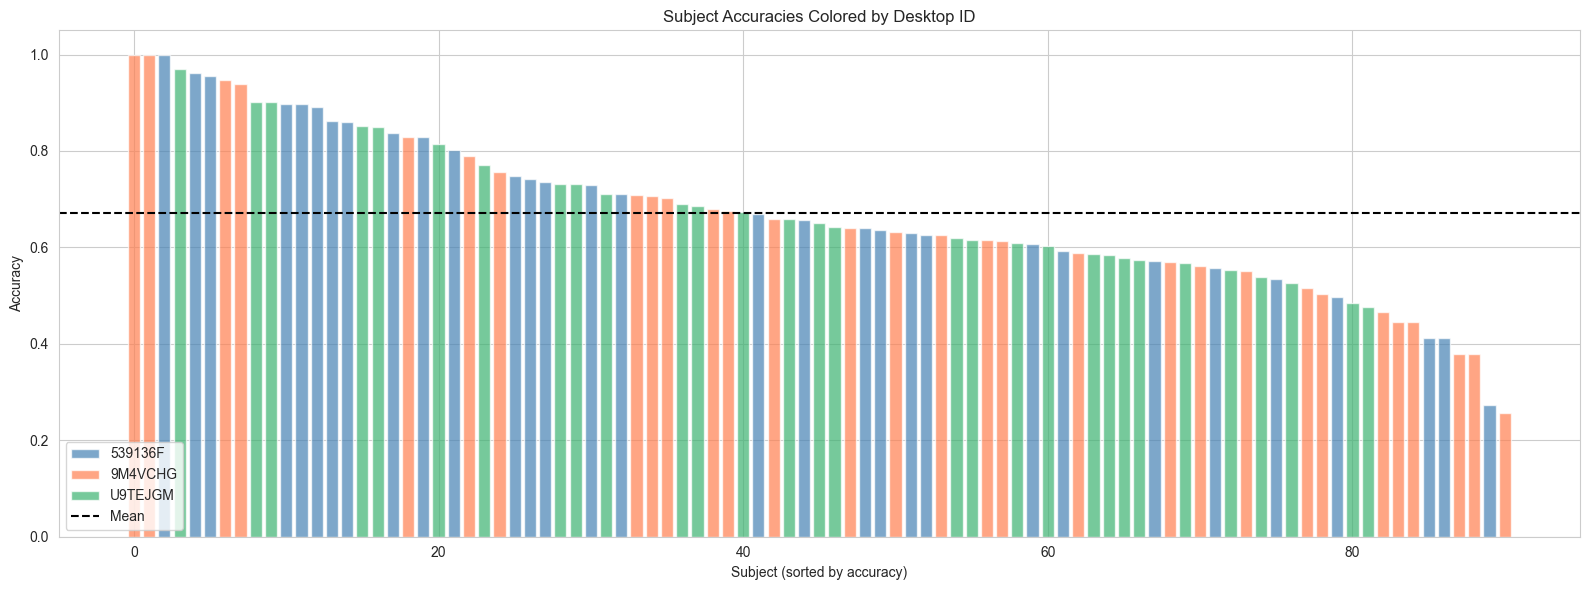

In [12]:
# Bar chart colored by desktop ID
desktop_colors = {
    '539136F': 'steelblue',
    '9M4VCHG': 'coral',
    'U9TEJGM': 'mediumseagreen',
    'A6I5HI6': 'purple',
    '4LI8GO7': 'gold'
}

plt.figure(figsize=(16, 6))
colors = [desktop_colors.get(d, 'gray') for d in analysis_df_sorted['desktop_id']]
plt.bar(range(len(analysis_df_sorted)), analysis_df_sorted['accuracy'], color=colors, alpha=0.7)
plt.xlabel('Subject (sorted by accuracy)')
plt.ylabel('Accuracy')
plt.title('Subject Accuracies Colored by Desktop ID')
plt.ylim(0, 1.05)
plt.axhline(y=analysis_df_sorted['accuracy'].mean(), color='black', linestyle='--', label='Mean')

# Legend
legend_elements = [
    Patch(facecolor=desktop_colors.get(d, 'gray'), alpha=0.7, label=d) 
    for d in sorted(analysis_df['desktop_id'].unique())
]
legend_elements.append(plt.Line2D([0], [0], color='black', linestyle='--', label='Mean'))
plt.legend(handles=legend_elements, loc='lower left')
plt.tight_layout()
plt.show()

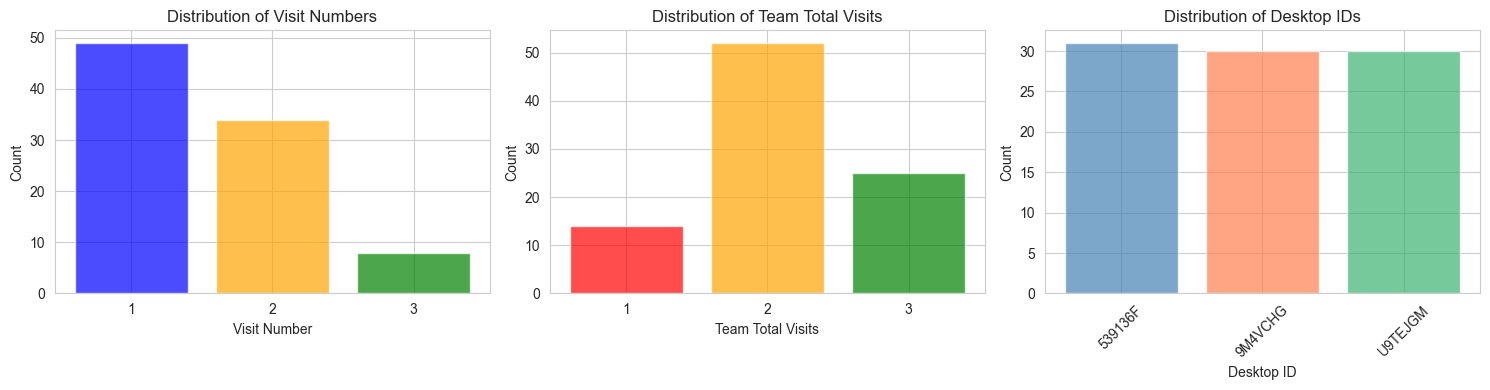

In [13]:
# Distribution plots
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Visit number distribution
visit_counts = analysis_df['visit_number'].value_counts().sort_index()
axes[0].bar(visit_counts.index, visit_counts.values, color=['blue', 'orange', 'green'], alpha=0.7)
axes[0].set_xlabel('Visit Number')
axes[0].set_ylabel('Count')
axes[0].set_title('Distribution of Visit Numbers')
axes[0].set_xticks([1, 2, 3])

# Team total visits distribution
team_counts = analysis_df['team_total_visits'].value_counts().sort_index()
axes[1].bar(team_counts.index, team_counts.values, color=['red', 'orange', 'green'], alpha=0.7)
axes[1].set_xlabel('Team Total Visits')
axes[1].set_ylabel('Count')
axes[1].set_title('Distribution of Team Total Visits')
axes[1].set_xticks([1, 2, 3])

# Desktop ID distribution
desktop_counts = analysis_df['desktop_id'].value_counts()
colors_desktop = [desktop_colors.get(d, 'gray') for d in desktop_counts.index]
axes[2].bar(range(len(desktop_counts)), desktop_counts.values, color=colors_desktop, alpha=0.7)
axes[2].set_xlabel('Desktop ID')
axes[2].set_ylabel('Count')
axes[2].set_title('Distribution of Desktop IDs')
axes[2].set_xticks(range(len(desktop_counts)))
axes[2].set_xticklabels(desktop_counts.index, rotation=45)

plt.tight_layout()
plt.show()

## Save Results to CSV

Exporting all results for later analysis without re-running.

In [14]:
import os
os.makedirs('../../data/results/fusion_model_results_POST', exist_ok=True)

# Save any comparison dataframes
for var_name in dir():
    var = eval(var_name)
    if isinstance(var, pd.DataFrame) and 'comparison' in var_name.lower():
        output_file = '../../data/results/fusion_model_results_POST/subject_repeat_analysis_POST_{var_name}.csv'
        var.to_csv(output_file, index=False)
        print(f"✓ Saved {var_name} to: {output_file}")

# Save results dictionaries as summary CSVs
if 'results_weighted' in locals():
    summary_data = []
    if isinstance(results_weighted, dict):
        for key, value in results_weighted.items():
            if isinstance(value, (int, float, str)):
                summary_data.append({'Metric': key, 'Value': value})
        if summary_data:
            summary_df = pd.DataFrame(summary_data)
            output_file = '../../data/results/fusion_model_results_POST/subject_repeat_analysis_POST_summary.csv'
            summary_df.to_csv(output_file, index=False)
            print(f"✓ Saved summary to: {output_file}")

print(f"\nResults saved to: ../../data/results/fusion_model_results_POST/")



Results saved to: ../../data/results/fusion_model_results_POST/
